In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
import matplotlib.pyplot as plt

from pytorch_lightning import LightningModule, Trainer
import torchvision.models as models
#from pl_bolts.callbacks import ORTCallback
import torchmetrics

from src.data_stuff import dataset_tools
import re


print('CUDA available:', torch.cuda.is_available())

CUDA available: True


# ⬇️ Data

In [2]:
ROOT_DIR = '/home/shatz/Documents/tcga_data/data/'
TRAIN_DIR = ROOT_DIR + 'train'
TEST_DIR = ROOT_DIR + 'test'

class params:
    num_workers = 6
    bs = 128

### Transforms
rgb_mean = (0.4914, 0.4822, 0.4465)
rgb_std = (0.2023, 0.1994, 0.2010)
train_tfms = torchvision.transforms.Compose([
    # torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(rgb_mean, rgb_std),
])
test_tfms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(rgb_mean, rgb_std),
])

### Datasets
train_ds = dataset_tools.ImageFolderWithPaths(TRAIN_DIR, train_tfms)
test_ds = dataset_tools.ImageFolderWithPaths(TEST_DIR, test_tfms)

# SUBSET FOR TESTING PURPOSES. DELETE LATER #
# train_ds = torch.utils.data.Subset(train_ds, np.random.randint(low=0, high=len(train_ds), size=int(len(train_ds)/8)))
# test_ds = torch.utils.data.Subset(test_ds, np.random.randint(low=0, high=len(test_ds), size=int(len(test_ds)/8)))

### Dataloaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=params.bs, num_workers=params.num_workers, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=params.bs, num_workers=params.num_workers, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


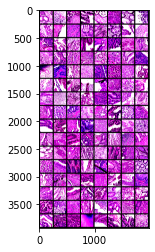

In [3]:
images = next(iter(train_dl))[1]
plt.imshow(torchvision.utils.make_grid(images, padding=20).permute(1, 2, 0))

In [4]:
len(train_ds)

93408

# Model

In [5]:
from src.model_stuff import MyResNet

In [6]:
model = MyResNet.MyResNet()
trainer = Trainer(gpus=1, max_epochs=40)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
#IN TRAINER: , callbacks=ORTCallback()
trainer.fit(model, train_dataloader=train_dl, val_dataloaders=test_dl)

/home/shatz/miniconda3/envs/moti/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:531: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | model    | ResNet            | 21.5 M
1 | criteria | BCEWithLogitsLoss | 0     
-----------------------------------------------
21.5 M    Trainable params
0         Non-trainable params
21.5 M    Total params
86.193    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/shatz/Documents/tcga_data/colorectal_cancer_ai/src/model_stuff/MyResNet.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_patient_score = torch.tensor(val_patient_score)
/home/shatz/Documents/tcga_data/colorectal_cancer_ai/src/model_stuff/MyResNet.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_patient_target = torch.tensor(self.all_patient_targets[patient])


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/shatz/Documents/tcga_data/colorectal_cancer_ai/src/model_stuff/MyResNet.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_patient_score = torch.tensor(train_patient_score)
/home/shatz/Documents/tcga_data/colorectal_cancer_ai/src/model_stuff/MyResNet.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_patient_target = torch.tensor(self.all_patient_targets[patient])


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
# !jupyter notebook stop 8888